In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.preprocessing import StandardScaler      # For scaling data
from sklearn.preprocessing import LabelEncoder        # For encoding labels
from sklearn.metrics import accuracy_score            # For evaluating the model performance
from sklearn.metrics import confusion_matrix
data= pd.read_csv(r"C:\Users\SP23-BBD-014.CUI\Desktop\projects\datasets\smart_home_energy_consumption.csv")

In [2]:
data.columns

Index(['Timestamp', 'Device ID', 'Device Type', 'Power Consumption (W)',
       'Room Location', 'Temperature (°C)', 'Humidity (%)',
       'Usage Duration (minutes)', 'Energy Cost ($)', 'On/Off Status'],
      dtype='object')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import gradio as gr

# Load dataset
data = pd.read_csv(r"C:\Users\SP23-BBD-014.CUI\Desktop\projects\datasets\smart_home_energy_consumption.csv")

# Convert efficiency to binary classification problem
median_cost = data['Energy Cost ($)'].median()
data['Is_Efficient'] = (data['Energy Cost ($)'] <= median_cost).astype(int)

# Feature Engineering
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Power_Duration_Ratio'] = data['Power Consumption (W)'] / data['Usage Duration (minutes)']
data['Temp_Humidity_Interaction'] = data['Temperature (°C)'] * data['Humidity (%)']

# Define features and target
X = data.drop(['Is_Efficient', 'Energy Cost ($)', 'Timestamp', 'Device ID', 'On/Off Status'], axis=1)
y = data['Is_Efficient']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
categorical_features = ['Device Type', 'Room Location']
numerical_features = ['Power Consumption (W)', 'Temperature (°C)', 'Humidity (%)', 
                      'Usage Duration (minutes)', 'Hour', 'DayOfWeek', 
                      'Power_Duration_Ratio', 'Temp_Humidity_Interaction']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Logistic Regression Pipeline
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train model
lr_pipe.fit(X_train, y_train)

# Save model with joblib
joblib.dump(lr_pipe, 'efficiency_logreg_model.joblib')

# Evaluation
y_pred = lr_pipe.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Gradio Interface
def predict_efficiency(device_type, room, power, temp, humidity, duration, hour, dayofweek):
    try:
        # Create input dataframe with exact column names
        input_df = pd.DataFrame({
            'Device Type': [device_type],
            'Room Location': [room],
            'Power Consumption (W)': [power],
            'Temperature (°C)': [temp],
            'Humidity (%)': [humidity],
            'Usage Duration (minutes)': [duration],
            'Hour': [hour],
            'DayOfWeek': [dayofweek],
            'Power_Duration_Ratio': [power / max(duration, 1)],
            'Temp_Humidity_Interaction': [temp * humidity]
        })
        
        # Make prediction
        prediction = lr_pipe.predict(input_df)[0]
        probability = lr_pipe.predict_proba(input_df)[0][1]
        
        return {
            "Prediction": "Efficient" if prediction == 1 else "Inefficient",
            "Probability": f"{probability:.2%}",
            "Details": f"The device is classified as {'efficient' if prediction == 1 else 'inefficient'} with {probability:.2%} confidence"
        }
    except Exception as e:
        return f"Error: {str(e)}"

# Create Gradio interface
inputs = [
    gr.Dropdown(["Washing Machine", "Laptop Charger", "Smart Bulb", "Heater"], label="Device Type"),
    gr.Dropdown(["Garage", "Bedroom", "Living Room", "Bathroom"], label="Room Location"),
    gr.Slider(0, 3000, step=0.1, label="Power Consumption (W)"),
    gr.Slider(-10, 40, step=0.1, label="Temperature (°C)"),
    gr.Slider(0, 100, step=0.1, label="Humidity (%)"),
    gr.Slider(1, 240, step=1, label="Usage Duration (minutes)"),
    gr.Slider(0, 23, step=1, label="Hour of Day"),
    gr.Slider(0, 6, step=1, label="Day of Week (0=Monday)")
]

outputs = gr.JSON(label="Efficiency Prediction")

# Add sample data for quick testing
sample_data = [
    "Washing Machine", "Garage", 350.0, 22.5, 45.0, 60, 14, 2
]

# Create interface
interface = gr.Interface(
    fn=predict_efficiency, 
    inputs=inputs, 
    outputs=outputs,
    title="Smart Home Device Efficiency Predictor",
    description="Predict energy efficiency of smart home devices based on usage patterns",
    examples=[sample_data]
)

# Launch the interface
interface.launch()

c:\Users\SP23-BBD-014.CUI\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\SP23-BBD-014.CUI\AppData\Local\Temp\ipykernel_11632\3815538200.py:20: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])


Confusion Matrix:
[[4775  214]
 [ 160 4851]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4989
           1       0.96      0.97      0.96      5011

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [4]:
data.isnull()

Timestamp  Device ID  Device Type  Power Consumption (W)  \
0          False      False        False                  False   
1          False      False        False                  False   
2          False      False        False                  False   
3          False      False        False                  False   
4          False      False        False                  False   
...          ...        ...          ...                    ...   
49995      False      False        False                  False   
49996      False      False        False                  False   
49997      False      False        False                  False   
49998      False      False        False                  False   
49999      False      False        False                  False   

       Room Location  Temperature (°C)  Humidity (%)  \
0              False             False         False   
1              False             False         False   
2              False             False         False   
3              False             False         False   
4              False             False         False   
...              ...               ...           ...   
49995          False             False         False   
49996          False             False         False   
49997          False             False         False   
49998          False             False         False   
49999          False             False         False   

       Usage Duration (minutes)  Energy Cost ($)  On/Off Status  Is_Efficient  \
0                         False            False          False         False   
1                         False            False          False         False   
2                         False            False          False         False   
3                         False            False          False         False   
4                         False            False          False         False   
...                         ...              ...            ...           ...   
49995                     False            False          False         False   
49996                     False            False          False         False   
49997                     False            False          False         False   
49998                     False            False          False         False   
49999                     False            False          False         False   

        Hour  DayOfWeek  Power_Duration_Ratio  Temp_Humidity_Interaction  
0      False      False                 False                      False  
1      False      False                 False                      False  
2      False      False                 False                      False  
3      False      False                 False                      False  
4      False      False                 False                      False  
...      ...        ...                   ...                        ...  
49995  False      False                 False                      False  
49996  False      False                 False                      False  
49997  False      False                 False                      False  
49998  False      False                 False                      False  
49999  False      False                 False                      False  

[50000 rows x 15 columns]

In [5]:
data.isnull().sum()

Timestamp                    0
Device ID                    0
Device Type                  0
Power Consumption (W)        0
Room Location                0
Temperature (°C)             0
Humidity (%)                 0
Usage Duration (minutes)     0
Energy Cost ($)              0
On/Off Status                0
Is_Efficient                 0
Hour                         0
DayOfWeek                    0
Power_Duration_Ratio         0
Temp_Humidity_Interaction    0
dtype: int64

In [6]:
data.describe()

Timestamp  Power Consumption (W)  Temperature (°C)  \
count                          50000           50000.000000      50000.000000   
mean   2024-07-01 14:19:18.260399872             570.842000         22.499879   
min              2024-01-01 00:15:00               2.500000         15.000000   
25%              2024-03-31 21:22:30              50.960000         18.760000   
50%              2024-07-01 08:53:00             134.725000         22.500000   
75%              2024-10-01 15:38:00            1013.857500         26.220000   
max              2024-12-30 23:59:00            2999.710000         30.000000   
std                              NaN             743.596529          4.321193   

       Humidity (%)  Usage Duration (minutes)  Energy Cost ($)  Is_Efficient  \
count  50000.000000              50000.000000     50000.000000  50000.000000   
mean      54.993893                 90.418140       103.312700      0.500000   
min       30.000000                  1.000000         0.010000      0.000000   
25%       42.420000                 46.000000         4.040000      0.000000   
50%       54.980000                 90.000000        22.605000      0.500000   
75%       67.450000                135.000000       130.152500      1.000000   
max       80.000000                179.000000      1041.140000      1.000000   
std       14.469001                 51.659167       165.772992      0.500005   

               Hour    DayOfWeek  Power_Duration_Ratio  \
count  50000.000000  50000.00000          50000.000000   
mean      11.499700      2.98954             18.007931   
min        0.000000      0.00000              0.014157   
25%        5.000000      1.00000              0.520319   
50%       11.000000      3.00000              2.342538   
75%       18.000000      5.00000             12.167491   
max       23.000000      6.00000           2950.270000   
std        6.926269      2.00564             85.426185   

       Temp_Humidity_Interaction  
count               50000.000000  
mean                 1237.225031  
min                   454.058100  
25%                   919.441575  
50%                  1189.308550  
75%                  1515.763225  
max                  2392.201800  
std                   407.788571

In [7]:
data.dtypes

Timestamp                    datetime64[ns]
Device ID                            object
Device Type                          object
Power Consumption (W)               float64
Room Location                        object
Temperature (°C)                    float64
Humidity (%)                        float64
Usage Duration (minutes)              int64
Energy Cost ($)                     float64
On/Off Status                        object
Is_Efficient                          int64
Hour                                  int32
DayOfWeek                             int32
Power_Duration_Ratio                float64
Temp_Humidity_Interaction           float64
dtype: object

In [8]:
import seaborn as sns

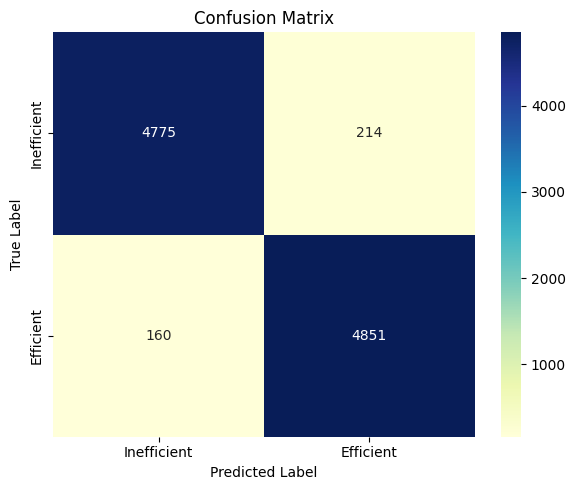

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot colorful confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Inefficient', 'Efficient'], yticklabels=['Inefficient', 'Efficient'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
